# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
%matplotlib inline

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker 
import seaborn as sns
import plotly.express as px
import datetime as dt
import os
import glob
import random
import zipfile

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')
clear_output()

# 1. Load Data

In [ ]:
# Set File Paths
PATH_01 = '/content/Structured Data/Train'
PATH_02 = '/content/Structured Data/Test'

In [ ]:
# Get paths of every single .csv file
train_dirs = glob.glob(PATH_01+ '/*.csv')
train_dirs.sort()
test_dirs = glob.glob(PATH_02+ '/*.csv')
test_dirs.sort()

In [ ]:
train_dirs

['/content/Structured Data/Train/2020_01_JAN.csv',
 '/content/Structured Data/Train/2020_02_FEB.csv',
 '/content/Structured Data/Train/2020_03_MAR.csv',
 '/content/Structured Data/Train/2020_04_APR.csv',
 '/content/Structured Data/Train/2020_05_MAY.csv',
 '/content/Structured Data/Train/2020_06_JUN.csv',
 '/content/Structured Data/Train/2020_07_JUL.csv',
 '/content/Structured Data/Train/2020_08_AUG.csv',
 '/content/Structured Data/Train/2020_09_SEP.csv',
 '/content/Structured Data/Train/2020_10_OCT.csv',
 '/content/Structured Data/Train/2020_11_NOV.csv',
 '/content/Structured Data/Train/2020_12_DEC.csv',
 '/content/Structured Data/Train/2021_01_JAN.csv',
 '/content/Structured Data/Train/2021_02_FEB.csv',
 '/content/Structured Data/Train/2021_03_MAR.csv',
 '/content/Structured Data/Train/2021_04_APR.csv',
 '/content/Structured Data/Train/2021_05_MAY.csv',
 '/content/Structured Data/Train/high_freq_2019.csv',
 '/content/Structured Data/Train/production_train.csv']

In [ ]:
test_dirs

['/content/Structured Data/Test/2020_01_JAN.csv',
 '/content/Structured Data/Test/2020_02_FEB.csv',
 '/content/Structured Data/Test/2020_03_MAR.csv',
 '/content/Structured Data/Test/2020_04_APR.csv',
 '/content/Structured Data/Test/2020_05_MAY.csv',
 '/content/Structured Data/Test/2020_06_JUN.csv',
 '/content/Structured Data/Test/2020_07_JUL.csv',
 '/content/Structured Data/Test/2020_08_AUG.csv',
 '/content/Structured Data/Test/2020_09_SEP.csv',
 '/content/Structured Data/Test/2020_10_OCT.csv',
 '/content/Structured Data/Test/2020_11_NOV.csv',
 '/content/Structured Data/Test/2020_12_DEC.csv',
 '/content/Structured Data/Test/2021_01_JAN.csv',
 '/content/Structured Data/Test/2021_02_FEB.csv',
 '/content/Structured Data/Test/2021_03_MAR.csv',
 '/content/Structured Data/Test/2021_04_APR.csv',
 '/content/Structured Data/Test/2021_05_MAY.csv',
 '/content/Structured Data/Test/high_freq_2019.csv',
 '/content/Structured Data/Test/production_test.csv']

# 2. Data Structuring

##2.1 Concat High Frequency Files

In [ ]:
# Concat Frequency Files
def concat_data(files):
    
    dataframes = []
    for i in range(len(files)):
        locals()['df'+f'{i}'] = pd.read_csv(files[i],parse_dates=[1])
        dataframes.append(locals()['df'+f'{i}'])
    return pd.concat(dataframes,axis=0).reset_index().drop('index',axis=1)

In [ ]:
# Concat High Frequency Data
train = concat_data(train_dirs[:-1])
train = train.sort_values(by=['DATE']).reset_index().drop('index',1)

test = concat_data(test_dirs[:-1])
test = test.sort_values(by=['DATE']).reset_index().drop('index',1)

In [ ]:
# Read Production Data
production_train = pd.read_csv(train_dirs[-1],parse_dates=[1])
production_train = production_train.sort_values(by=['DATE']).reset_index().drop('index',1)

production_test = pd.read_csv(test_dirs[-1],parse_dates=[1])
production_test = production_test.sort_values(by=['DATE']).reset_index().drop('index',1)

##2.2 Drop repeated Columns



<h5> <b>PRESS_INT & PRESS_INTK</b> refer to the same thing (Intake Pressure), however the second is used only for the values of 2019.
<h5> <b>TEMP_INT & TEMP_INTK</b> refer to the same thing (Intake Temperature), however the second is used only for the values of 2019.

In [ ]:
# Therefore, we can run the next instruction to merge both columns

train['PRESS_INT'] = train['PRESS_INT'].fillna(train['PRESS_INTK'])
train['TEMP_INT'] = train['TEMP_INT'].fillna(train['TEMP_INTK'])
test['PRESS_INT'] = test['PRESS_INT'].fillna(test['PRESS_INTK'])
test['TEMP_INT'] = test['TEMP_INT'].fillna(test['TEMP_INTK'])

del train['PRESS_INTK']
del train['TEMP_INTK']
del test['PRESS_INTK']
del test['TEMP_INTK']

In [ ]:
train_wells = train['WELL_ID'].unique()
test_wells = test['WELL_ID'].unique()

print('Train wells: ',len(train_wells))
print('Test wells: ',len(test_wells))

Train wells:  100
Test wells:  15


## 2.3 Merge High Frequency & Production Data

In [ ]:
# Define a function to merge High_Frequency Data with Production Data
# This function takes 1.84 hours to run

def structurer(wells,production_data,high_freq_data):

  df = []

  for well in wells:                                                            # Loop over well list (train/test)

    pump = production_data[production_data['WELL_ID'] == well]                  # Select production data for the looped-in well
    pump = pump[pump['DATE'].dt.year>=2019].sort_values(by=['DATE'])            # Select data from 2019 onwards 
    duplicated = pump[pump['DATE'].duplicated(keep=False)]                      # Find Duplicated Values
    idx_2ptd = duplicated[duplicated['PIP(PSI)'].isnull()].index                # Get index of Duplicated Values
    pump = pump.drop(index=idx_2ptd).reset_index().drop('index',1)              # Drop Duplicated Rows with missing Values

    pump = pump.set_index('DATE').asfreq('d',method='pad')                      # Set frequency of dates by one day & Fill missing values 
    pump = pump.fillna(method='ffill') 
    pump = pump.reset_index()

    sensor = high_freq_data[high_freq_data['WELL_ID'] == well]                  # Select high frequency data for the looped-in well
    sensor = sensor.drop_duplicates().reset_index().drop('index',1)             # Drop Duplicated Values

    sensor_dates = sensor['DATE'].unique()                                      # Get High Frequency Dates
    pump_dates = pump['DATE'].unique()                                          # Get Production Dates

    merged = []

    try:

      for _ in pump_dates:                                                      # Loop over production dates

        if _ in sensor_dates:                                                   # If production date in sensor dates
          time = pd.Timestamp(_)                                                  
          shot = sensor[sensor['DATE'].dt.date == (dt.date(time.year, time.month, time.day))].reset_index().drop('index',1) # Select all rows from sensor data equal to the "looped-in" production date
          bullet = pump[pump['DATE'].dt.date == time].reset_index().drop('index',1) # Select production information regarding looping date 

          for i in bullet.keys().drop(['WELL_ID','DATE']):
            shot[i] = bullet.loc[0,i]                                           # Append Production columns to sensor data 
          merged.append(shot)                                                   # Append merged data to a list

        else:                                                                   # If production date not in sensor dates
          
          time = pd.Timestamp(_)

          year, month = time.year, time.month                                   # Gete year and month
          sun = sensor[sensor['DATE'].dt.year == year]                          # Select sensor data from that year
          moon = sun[sun['DATE'].dt.month == month].reset_index().drop('index',1) # Select sensor data from that month
          bullet = pump[pump['DATE'].dt.date == time].reset_index().drop('index',1) # Select production information regarding looping date  

          if len(moon) != 0:
            closest = min(list(moon['DATE'].dt.date), key = lambda sub: abs(np.datetime64(sub) - np.datetime64(time))) # Get the closest date from sensor data to looping production date
            
            if abs(np.datetime64(closest) - np.datetime64(time)).astype('timedelta64[D]') <= dt.timedelta(days=1): # If closest date and looping date differ by up to 1 day       
              for i in bullet.keys().drop(['WELL_ID','DATE']):
                moon = moon[moon['DATE'].dt.date == dt.date(closest.year, closest.month, closest.day)] # Select all the the rows from sensor data related to closest date
                moon[i] = bullet.loc[0,i]                                       # Append Production columns to sensor data 
              merged.append(moon)                                               # Append merged data to a list

      merged = pd.concat(merged,0).reset_index().drop('index',1)                # Once all the production dates are looped, concat the list with merged data
      merged = merged.drop_duplicates(subset='DATE',keep='last')                # Drop duplicated values
      df.append(merged)                                                         # Append Merged data of looped-in well to a list

    except:
      print(well)
                                                          
  return pd.concat(df,axis=0).reset_index().drop('index',1)

In [ ]:
"""
  Structure Train & Test Data
"""
structured_train = structurer(train_wells,production_train,train)
structured_test = structurer(test_wells,production_test,test)

DEEPWATER-1WHBG2


tcmalloc: large alloc 1383530496 bytes == 0x55a49961c000 @  0x7f394c7101e7 0x7f3942f4846e 0x7f3942f98c7b 0x7f3942f98d18 0x7f3943040010 0x7f394304073c 0x7f394304085d 0x55a311b452b8 0x7f3942f85ef7 0x55a311b42f97 0x55a311b42da0 0x55a311bb6bb3 0x55a311bb1c35 0x55a311b4473a 0x55a311bb6f40 0x55a311a83d14 0x7f3942f85ef7 0x55a311b42f97 0x55a311b42da0 0x55a311bb6bb3 0x55a311bb1c35 0x55a311b4473a 0x55a311bb6f40 0x55a311bb1c35 0x55a311b4473a 0x55a311bb393b 0x55a311b4465a 0x55a311bb2b0e 0x55a311b4465a 0x55a311bb2d67 0x55a311b4465a
tcmalloc: large alloc 1383530496 bytes == 0x55a4ec590000 @  0x7f394c7101e7 0x7f3942f4846e 0x7f3942f98c7b 0x7f3942f98d18 0x7f394302b3a9 0x7f394302dab5 0x55a311c2b119 0x55a311bb307e 0x55a311bb1c35 0x55a311b4473a 0x55a311bb393b 0x55a311b4465a 0x55a311bb2b0e 0x55a311b4465a 0x55a311bb2d67 0x55a311b4465a 0x55a311bb2d67 0x55a311bb1dcc 0x55a311b4473a 0x55a311bb2b0e 0x55a311b4465a 0x55a311bb6f40 0x55a311bb2235 0x55a311b4473a 0x55a311bb6f40 0x55a311bb2235 0x55a311b44fec 0x55a311b4

In [ ]:
# Number of wells in Structured Train Data
len(structured_train['WELL_ID'].unique())

99

In [ ]:
# Previous Outputs
train['WellFailure'].value_counts()

yes           88
Manual off    23
Name: WellFailure, dtype: int64

In [ ]:
# Current Outputs
structured_train['WellFailure'].value_counts()

yes           86
Manual off    20
Name: WellFailure, dtype: int64

In [ ]:
# Look for wells with no outputs
pd.set_option('max_rows',105)
structured_data.groupby(by=['WELL_ID'])['WellFailure'].unique()

WELL_ID
DEEPWATER-000XAR                [nan, yes]
DEEPWATER-05YWY5                [nan, yes]
DEEPWATER-0KPXEZ         [nan, Manual off]
DEEPWATER-0SSSKO                [nan, yes]
DEEPWATER-1AD32W                [nan, yes]
DEEPWATER-1P54OE                [nan, yes]
DEEPWATER-1UBHZV    [nan, yes, Manual off]
DEEPWATER-1WOOJU                [nan, yes]
DEEPWATER-2MK4DS         [nan, Manual off]
DEEPWATER-34JETX                [nan, yes]
DEEPWATER-3FD330         [nan, Manual off]
DEEPWATER-3J5ZXG                [nan, yes]
DEEPWATER-3PEB5I                [nan, yes]
DEEPWATER-453GJ0         [nan, Manual off]
DEEPWATER-4TYG1P                [nan, yes]
DEEPWATER-51ZYBC         [nan, Manual off]
DEEPWATER-55KSI1         [nan, Manual off]
DEEPWATER-55X0XE                     [nan]
DEEPWATER-5DEUPB         [nan, Manual off]
DEEPWATER-5MZAFB         [nan, Manual off]
DEEPWATER-5RY0MV                [nan, yes]
DEEPWATER-A5W4QG                [nan, yes]
DEEPWATER-AHJLPP                [nan, yes]
DEE

In [ ]:
to_remove = ['DEEPWATER-55X0XE', 'DEEPWATER-D4EH50', 'DEEPWATER-ZISKRZ']
idxs = []

for i in to_remove:
  idx = structured_train[structured_train['WELL_ID']==i].index
  idxs.append(idx)

structured_train = structured_train.drop(np.hstack(idxs))

In [ ]:
structured_train

WELL_ID                DATE  ...     PUMP  PSI_CAB
0        DEEPWATER-TPS1RK 2019-02-25 00:00:00  ...  ESP-580     40.0
1        DEEPWATER-TPS1RK 2019-02-26 00:00:00  ...  ESP-580     40.0
2        DEEPWATER-TPS1RK 2019-02-27 00:00:00  ...  ESP-580     40.0
3        DEEPWATER-TPS1RK 2019-02-28 00:00:00  ...  ESP-580     40.0
4        DEEPWATER-TPS1RK 2019-03-01 00:00:00  ...  ESP-580     40.0
...                   ...                 ...  ...      ...      ...
8235283  DEEPWATER-LSHIAK 2021-05-25 07:59:49  ...  ESP-411     80.0
8235284  DEEPWATER-LSHIAK 2021-05-25 08:19:39  ...  ESP-411     80.0
8235285  DEEPWATER-LSHIAK 2021-05-25 08:39:30  ...  ESP-411     80.0
8235286  DEEPWATER-LSHIAK 2021-05-25 08:59:21  ...  ESP-411     80.0
8235287  DEEPWATER-LSHIAK 2021-05-25 09:19:11  ...  ESP-411     80.0

[8143809 rows x 25 columns]

# 3. Data Visualization

## 3.1 Plot Historical Data

In [ ]:
# Replace Well_id's and Event strings by numbers for plotting purposes:

nums = np.arange(1,len(structured_train['WELL_ID'].unique())+1)
train_dict = dict(zip(structured_train['WELL_ID'].unique(),nums))

structured_train['WELL_ID'] = structured_train['WELL_ID'].replace(train_dict)
structured_train['FAILURE'] = structured_train['WellFailure'].replace(to_replace={np.nan:0,'yes':1,'Manual off':2})

# Define a function to get isolated dataframes by well numbers
def well(id):
  one = structured_train[structured_train['WELL_ID']==id].sort_values(by=['DATE'])
  return one.set_index('DATE')

In [ ]:
def event_plotter(df,parameters):  

  fig = plt.figure(figsize=(15,8))
  host = fig.add_subplot(111)

  ax1 = host.twinx()
  ax2 = host.twinx()
  ax3 = host.twinx()
  ax4 = host.twinx()
  
  host.set_ylabel(parameters[0])
  ax1.set_ylabel(parameters[1])
  ax2.set_ylabel(parameters[2])
  ax3.set_ylabel(parameters[3])
  ax4.set_ylabel(parameters[4])

  color1 = 'tab:blue'
  color2 = 'tab:green'
  color3 = 'tab:purple'
  color4 = 'tab:orange'
  color5 = 'tab:red'

  p1, = host.plot(df[parameters[0]], color= color1, label=parameters[0])
  p2, = ax1.plot(df[parameters[1]], color= color2, label=parameters[1])
  p3, = ax2.plot(df[parameters[2]], color= color3, label=parameters[2])
  p4, = ax3.plot(df[parameters[3]], color= color4, label=parameters[3])
  p5, = ax4.plot(df[parameters[4]], linewidth=4, color= color5, label=parameters[4]) 

  lns = [p1, p2, p3, p4, p5]

  ax2.spines['right'].set_position(('outward', 45))
  ax3.spines['right'].set_position(('outward', 90))
  ax4.spines['right'].set_position(('outward', 135))  

  ax1.xaxis.set_ticks([])          
  ax2.xaxis.set_ticks([])
  ax3.xaxis.set_ticks([])
  ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
  ax4.xaxis.set_major_locator(ticker.MultipleLocator(100)) 

  host.yaxis.label.set_color(p1.get_color())
  ax1.yaxis.label.set_color(p2.get_color())
  ax2.yaxis.label.set_color(p3.get_color())
  ax3.yaxis.label.set_color(p4.get_color())
  ax4.yaxis.label.set_color(p5.get_color())
  host.legend(handles=lns, frameon=True, shadow=False, borderpad=1, loc='best');

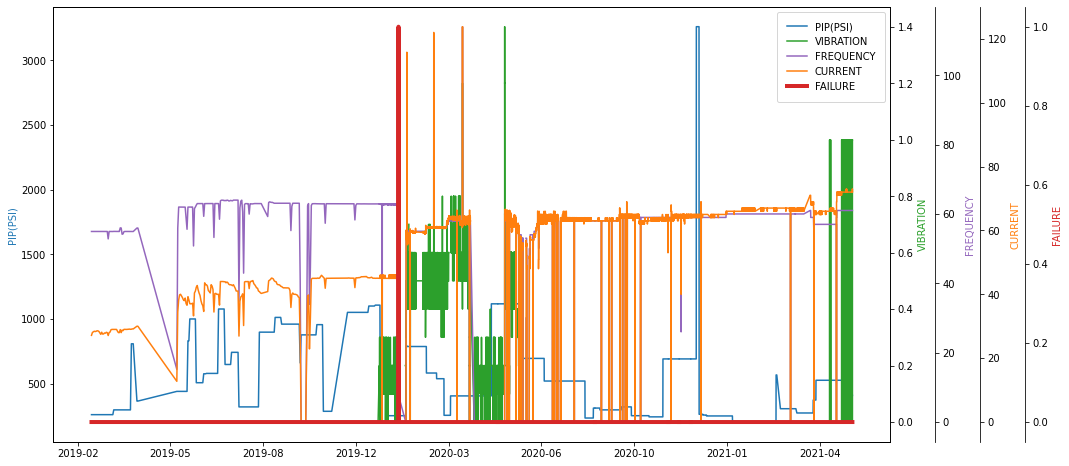

In [ ]:
event_plotter(well(1),['PIP(PSI)','VIBRATION', 'FREQUENCY', 'CURRENT','FAILURE'])

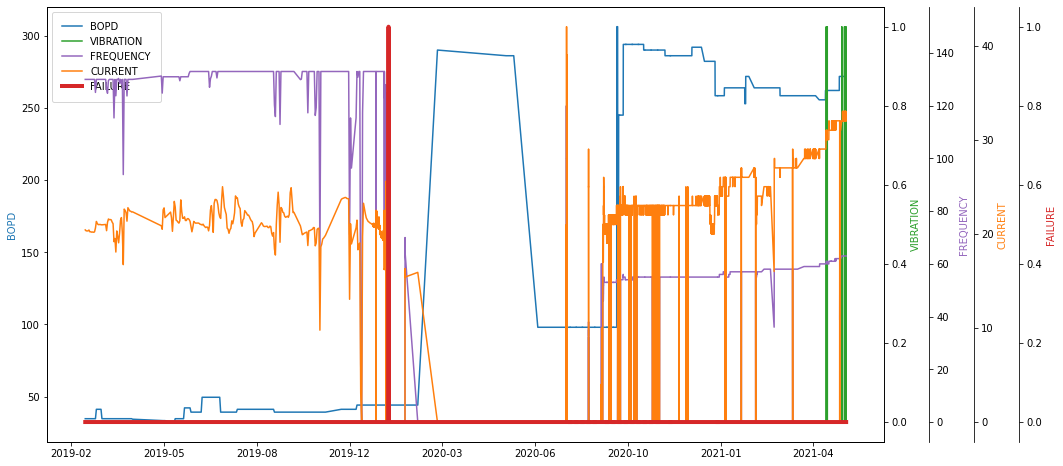

In [ ]:
event_plotter(well(2),['BOPD','VIBRATION', 'FREQUENCY', 'CURRENT','FAILURE'])

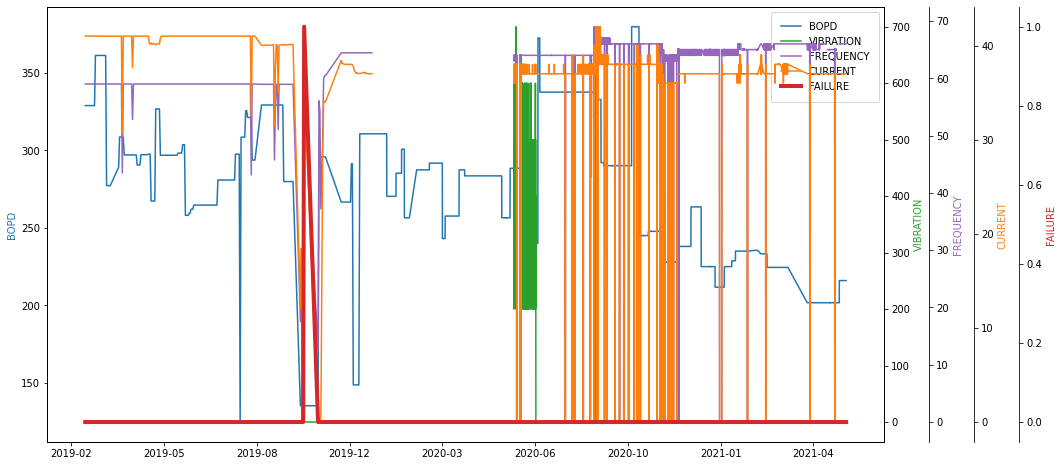

In [ ]:
event_plotter(well(3),['BOPD','VIBRATION', 'FREQUENCY', 'CURRENT','FAILURE'])

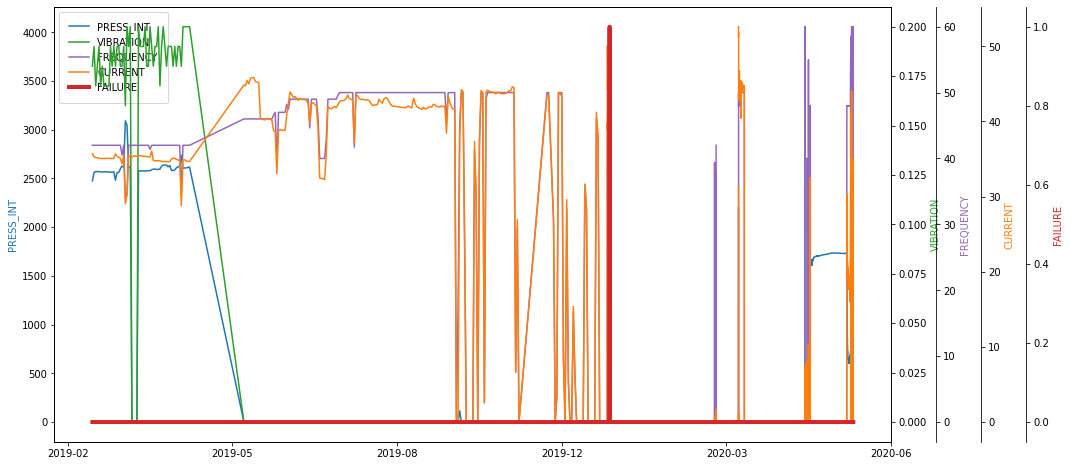

In [ ]:
event_plotter(well(46),['PRESS_INT','VIBRATION', 'FREQUENCY', 'CURRENT','FAILURE'])

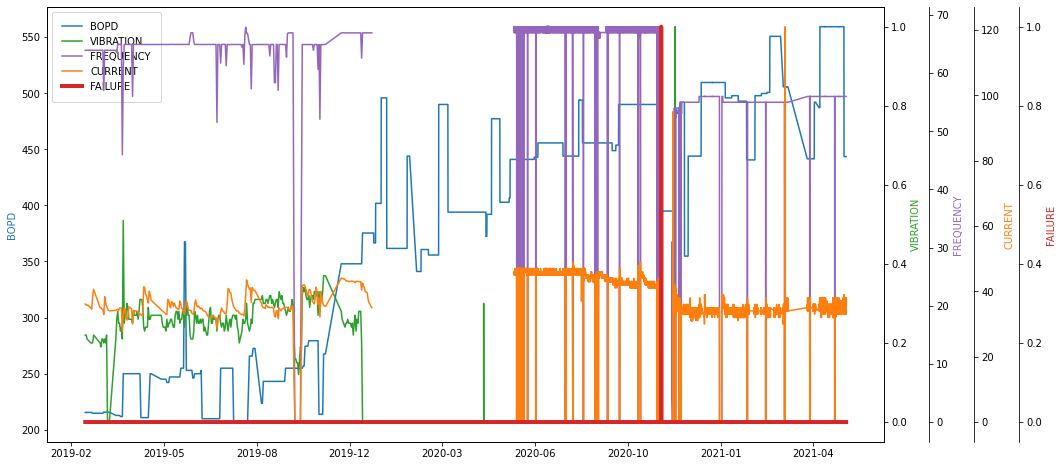

In [ ]:
event_plotter(well(57),['BOPD','VIBRATION', 'FREQUENCY', 'CURRENT','FAILURE'])

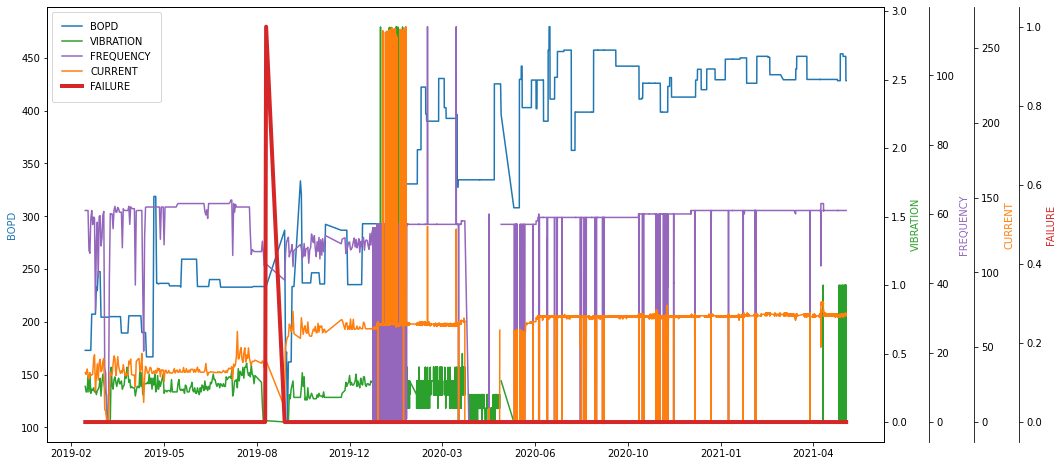

In [ ]:
event_plotter(well(6),['BOPD','VIBRATION', 'FREQUENCY', 'CURRENT','FAILURE'])

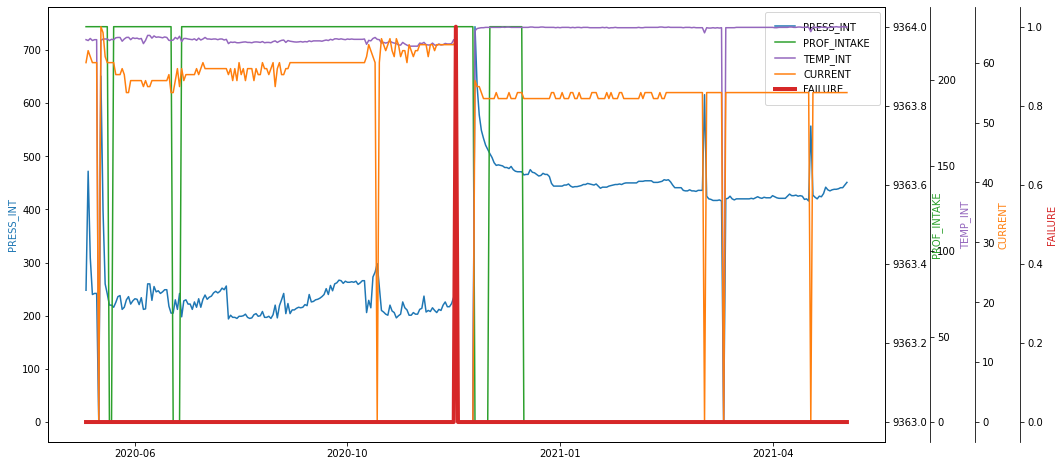

In [ ]:
event_plotter(hole(94),['PRESS_INT','PROF_INTAKE', 'TEMP_INT', 'CURRENT','FAILURE'])

## 3.2 Plot Well Locations

In [ ]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import mixture
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [ ]:
locations = pd.read_csv('well_locations.csv')

fig = px.scatter(locations, x=locations.lon, y=locations.lat,hover_data=[locations['WELL_ID']])
fig.update_layout(
    width = 500,
    height = 650,
    title = "Well Locations")

fig.show()

## 3.3 Get Neighbor Wells 

In [ ]:
coords = locations[['lon','lat']].values

In [ ]:
# This workflow for neighboring wells is adapted from:
# https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=60, cmap='viridis', zorder=1, alpha = 0.7, edgecolors='#000')

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], c = 'r', s = 200, zorder=1)
    ax.scatter(centers[:, 0], centers[:, 1], c = 'w', s = 35, zorder=2)
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=0))     

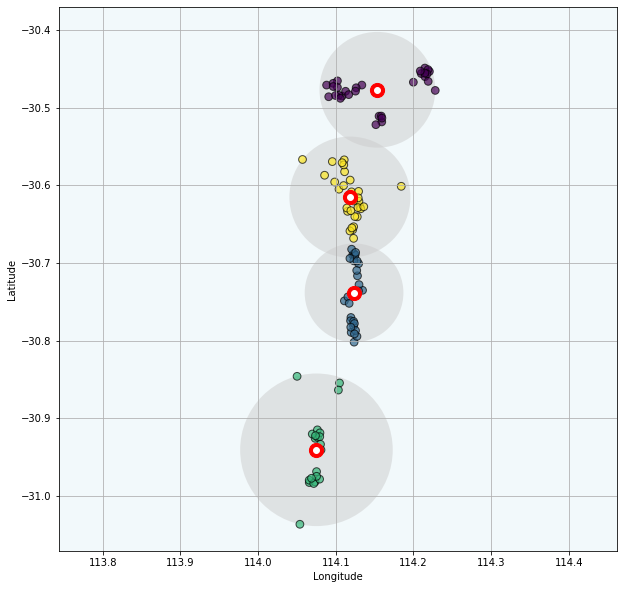

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)

fig = plt.figure(figsize=((10,10)))
plot_kmeans(kmeans, coords)
ax = plt.gca()
ax.set_facecolor('#f2f9fb')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.grid();

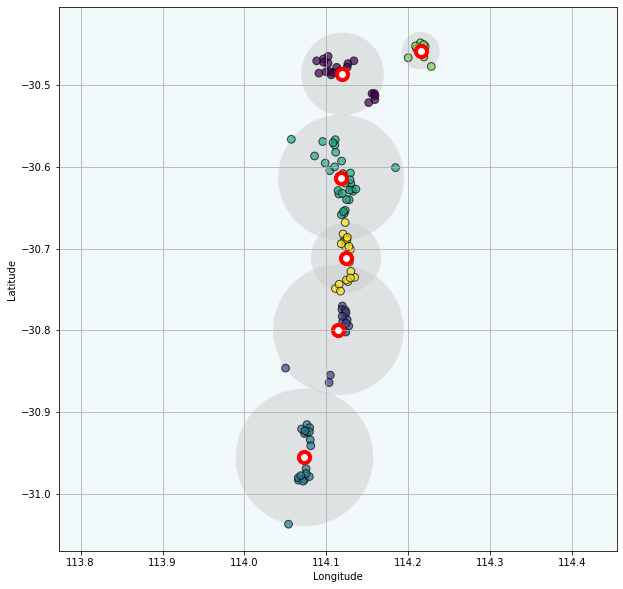

In [ ]:
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)

fig = plt.figure(figsize=((10,10)))
plot_kmeans(kmeans, coords)
ax = plt.gca()
ax.set_facecolor('#f2f9fb')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.grid();

In [ ]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, edgecolors='#000')
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2, edgecolors='#000')
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

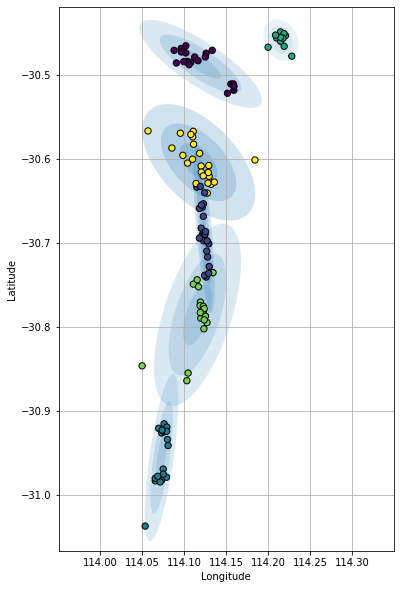

In [ ]:
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full', random_state=42).fit(coords)
plt.figure(figsize=((6,10)))
plot_gmm(gmm, coords)
ax = plt.gca()
ax.set_xlim(114,114.3)
ax.set_facecolor('white')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.grid();

In [ ]:
clusters = gmm.fit(coords).predict(coords)
locations['cluster'] = clusters

In [ ]:
pd.set_option('max_colwidth',100)
locations['WELL_ID'] = locations['WELL_ID'].replace(train_dict)

train_clusters = locations[locations['WELL_ID'].astype(str).str.isdigit()]
train_clusters = pd.DataFrame(train_clusters.groupby('cluster')['WELL_ID'].unique())
train_clusters

WELL_ID
cluster                                                                                       
0                  [38, 84, 78, 59, 71, 91, 13, 27, 42, 29, 74, 86, 41, 85, 1, 67, 19, 87, 88]
1        [22, 72, 30, 57, 6, 89, 60, 47, 79, 37, 81, 9, 25, 54, 61, 98, 83, 8, 31, 12, 90, 20]
2                                       [26, 24, 17, 93, 66, 40, 33, 80, 3, 49, 11, 58, 7, 52]
3                                                          [15, 4, 36, 50, 53, 95, 75, 94, 10]
4                              [39, 23, 65, 43, 14, 18, 63, 77, 99, 68, 64, 5, 34, 56, 28, 51]
5                  [48, 44, 92, 55, 32, 97, 73, 70, 69, 45, 21, 46, 96, 2, 16, 62, 76, 35, 82]

<h2> Normal Ranges

In [ ]:
"""
 - PIP: 180 - 2400 (PSI)
 - AMP: 20 - 90 (A)
 - FREQUENCY: 35 - 75 (Hz)
 - INTK TEMP: 175 - 232 (°F)
 - ENGINE TEMP: 250 - 355 (°F)
"""